In [41]:
from train_predictor import MaskPredFormer, MaskPredDataset
from predictor import Predictor
import random
import torch
import matplotlib.pyplot as plt
import numpy as np
import imageio

In [29]:
model = MaskPredFormer.load_from_checkpoint(
    "models/last.ckpt", 
    predictor=Predictor(),
    batch_size=1,
    lr=0.017,
    max_epochs=20
)

In [30]:
def apply_cm(x):
    cm = plt.get_cmap()
    norm = plt.Normalize(vmin=x.min(), vmax=x.max())
    return cm(norm(x))[:, :, :3].transpose(2,0,1)

In [31]:
model.eval();

In [32]:
val_dataset = MaskPredDataset("data_prepared", "val")

In [33]:
sample = val_dataset[random.randint(0, len(val_dataset))]
sample = sample.unsqueeze(0).to(model.device)
gt = sample.squeeze(0).cpu()

In [34]:
pred_ar = sample[:, :11]
with torch.no_grad():
    for t in range(11):
        _, pred_t, _ = model.common_step(pred_ar)
        pred_ar = torch.cat([pred_ar, pred_t[:, -1:]], dim=1)
    pred_ar = pred_ar.detach().cpu().squeeze(0)
pred_ar = pred_ar.detach().cpu().squeeze(0)

In [36]:
gt.shape

torch.Size([22, 49, 80, 120])

In [37]:
pred_imgs = []
pred_ar_imgs = []
gt_imgs = []
for t in range(pred_ar.shape[0]):
    pred_ar_img = apply_cm(torch.argmax(pred_ar[t], dim=0))
    gt_img = apply_cm(torch.argmax(gt[t], dim=0))
    pred_ar_imgs.append(pred_ar_img)
    gt_imgs.append(gt_img)

In [39]:
pred_ar_imgs = np.stack(pred_ar_imgs, axis=0)
gt_imgs = np.stack(gt_imgs, axis=0)
video = (np.concatenate([gt_imgs, pred_ar_imgs], axis=3) * 255).astype(np.uint8)

In [42]:
gif_path = "video_pred.gif"
with imageio.get_writer(gif_path, mode='I') as writer:
    for i in range(video.shape[0]):
        writer.append_data(video[i].transpose(1,2,0))
print("GIF saved")

GIF saved


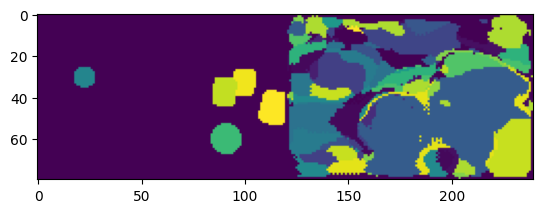